In [6]:
import numpy as np
from random import randint
import networkx as nx
from queue import SimpleQueue
from random import sample
from time import time
import matplotlib.pyplot as plt
import json

In [7]:
def E(G, colors):
    """
    An implementation of the Energy function.

    Parameters
    ----------
    G: a networkx Graph
    colors: an array of integers, colors[i] being the color of the i-th node of G
    
    Returns
    -------
    the value of the energy function
    """
    counts = np.bincount(colors)
    bad_edges = np.zeros(counts.shape[0]) 
    for node in G.nodes():
        for neighbor in G[node]:
            if colors[node] == colors[neighbor]:
                bad_edges[colors[node]] += 1

    return np.sum(counts @ bad_edges) / 2 - np.sum(np.square(counts))

In [8]:
def SOC(G, k, colors):
    """
    An implementation of the abelian sandpile model, run until an avalanche occurs and returns the set of nodes caught in it.
    
    Parameters
    ----------
    G: a networkx Graph
    k: the chosen threshold in the abelian sandpile model (here, the maximum value for a color)
    colors: an array of integers, colors[i] being the color of the i-th node of G

    Returns
    -------
    the set of nodes caught in the avalanche
    """
    avalanche = np.zeros(colors.shape[0], dtype=bool)

    node = randint(0, len(G.nodes)-1)
    while colors[node] < k:
        colors[node] += 1
        node = randint(0, len(G.nodes)-1)
    
    toppling = colors >= k
    avalanche = np.logical_or(avalanche, toppling)
    while np.any(np.logical_and(toppling, np.logical_not(avalanche))):
        colors[[np.any(toppling[G[node]]) for node in G.nodes]] += 1
        colors[toppling] = 0
        toppling = colors >= k
        avalanche = np.logical_or(avalanche, toppling)
                        
    return avalanche


In [9]:
def random_propag(G, colors):
    """
    An implementation of Model 2.

    Parameters
    ----------
    G: a networkx Graph
    colors: an array of integers, colors[i] being the color of the i-th node of G

    Returns
    -------
    the set of nodes selected by Model 2
    """
    nodes = set(np.random.choice(len(G.nodes), 1))
    new_nodes = nodes.union(set([v for node in nodes for v in G[node] if colors[v]==colors[node]]))

    while nodes != new_nodes:
        nodes = new_nodes
        new_nodes = nodes.union(set([v for node in nodes for v in G[node] if colors[v]==colors[node]]))
        
    res = np.zeros(len(G.nodes), dtype=bool)
    res[list(nodes)] = True
    return res

In [18]:
def preSOC(G, k, steps_number):
    """
    An implementation of the abelian sandpile model completing <steps_number> avalanches. It is used to reach SOC state.
    
    Parameters
    ----------
    G: a networkx Graph
    k: the chosen threshold in the abelian sandpile model (here, the maximum value for a color)
    steps_number: the number of avalanches the model should go through

    Returns
    -------
    the color map after <steps_number> avalanches
    """
    colors = np.random.randint(k,size=len(G.nodes))

    for i in range(steps_number):
        avalanche = np.zeros(colors.shape[0], dtype=bool)

        node = randint(0, len(G.nodes)-1)
        while colors[node] < k:
            colors[node] += 1
            node = randint(0, len(G.nodes)-1)
    
        toppling = colors >= k
        avalanche = np.logical_or(avalanche, toppling)
        while np.any(np.logical_and(toppling, np.logical_not(avalanche))):
            colors[[np.any(toppling[G[node]]) for node in G.nodes]] += 1
            colors[toppling] = 0
            toppling = colors >= k
            avalanche = np.logical_or(avalanche, toppling)
     
    return colors

In [19]:
def color(G, k, steps_number):
    """
    An implementation of SOC search.
 
    Parameters
    ----------
    G: a networkx Graph
    k: the chosen threshold in the abelian sandpile model (here, the maximum value for a color)
    steps_number: the number of avalanches the model should go through

    Returns
    -------
    colors: the color map found by SOC search 
    E_list: successive values of the energy function
    """
    colors = preSOC(G,k, 1000)
    E_list = np.zeros(steps_number, dtype=int)
    
    for step in range(steps_number):
        if step%(steps_number//100)==0:
            print("Current step: " +str(step))
        avalanche = SOC(G, k, np.copy(colors))
        new_colors = np.copy(colors)
        new_colors[avalanche] = np.random.randint(k-1, size=np.count_nonzero(avalanche))            
        
        if E(G, new_colors) < E(G, colors):
            E_list[step] = E(G, new_colors)
            colors = new_colors
            
        else:
            E_list[step] = E(G, colors)
        
        
        
    return colors, E_list

In [20]:
def color_random(G, k, steps_number):
    """
    An implementation of Model 1 search.
 
    Parameters
    ----------
    G: a networkx Graph
    k: the chosen threshold in the abelian sandpile model (here, the maximum value for a color)
    steps_number: the number of avalanches the model should go through

    Returns
    -------
    colors: the color map found by Model 1 search 
    E_list: successive values of the energy function
    """

    colors = preSOC(G,k, 1000)
    E_list = np.zeros(steps_number, dtype=int)
    
    for step in range(steps_number):
        if step%(steps_number//100)==0:
            print("Current step: " +str(step))
        new_colors = np.copy(colors)
        avalanche = np.zeros(new_colors.shape[0], dtype=bool)
        avalanche[np.random.randint(new_colors.shape[0], size=1)] = True
        new_colors[avalanche] = np.random.randint(k-1, size=np.count_nonzero(avalanche))            
        
        if E(G, new_colors) < E(G, colors):
            E_list[step] = E(G, new_colors)
            colors = new_colors
            
        else:
            E_list[step] = E(G, colors)
        
        
        
    return colors, E_list

In [21]:
def color_s(G, k, steps_number):
    """
    An implementation of Model 2 search.
 
    Parameters
    ----------
    G: a networkx Graph
    k: the chosen threshold in the abelian sandpile model (here, the maximum value for a color)
    steps_number: the number of avalanches the model should go through

    Returns
    -------
    colors: the color map found by Model 2 search 
    E_list: successive values of the energy function
    """

    colors = preSOC(G,k, 1000)
    E_list = np.zeros(steps_number)
    
    for step in range(steps_number):
        if step%(steps_number//100)==0:
            print("Current step: " +str(step))
        new_colors = np.copy(colors)
        avalanche = random_propag(G, new_colors)
        new_colors[avalanche] = np.random.randint(k-1, size=np.count_nonzero(avalanche))            
        
        if E(G, new_colors) < E(G, colors):
            E_list[step] = E(G, new_colors)
            colors = new_colors
            
        else:
            E_list[step] = E(G, colors)
        
        
        
    return colors, E_list

# Tests

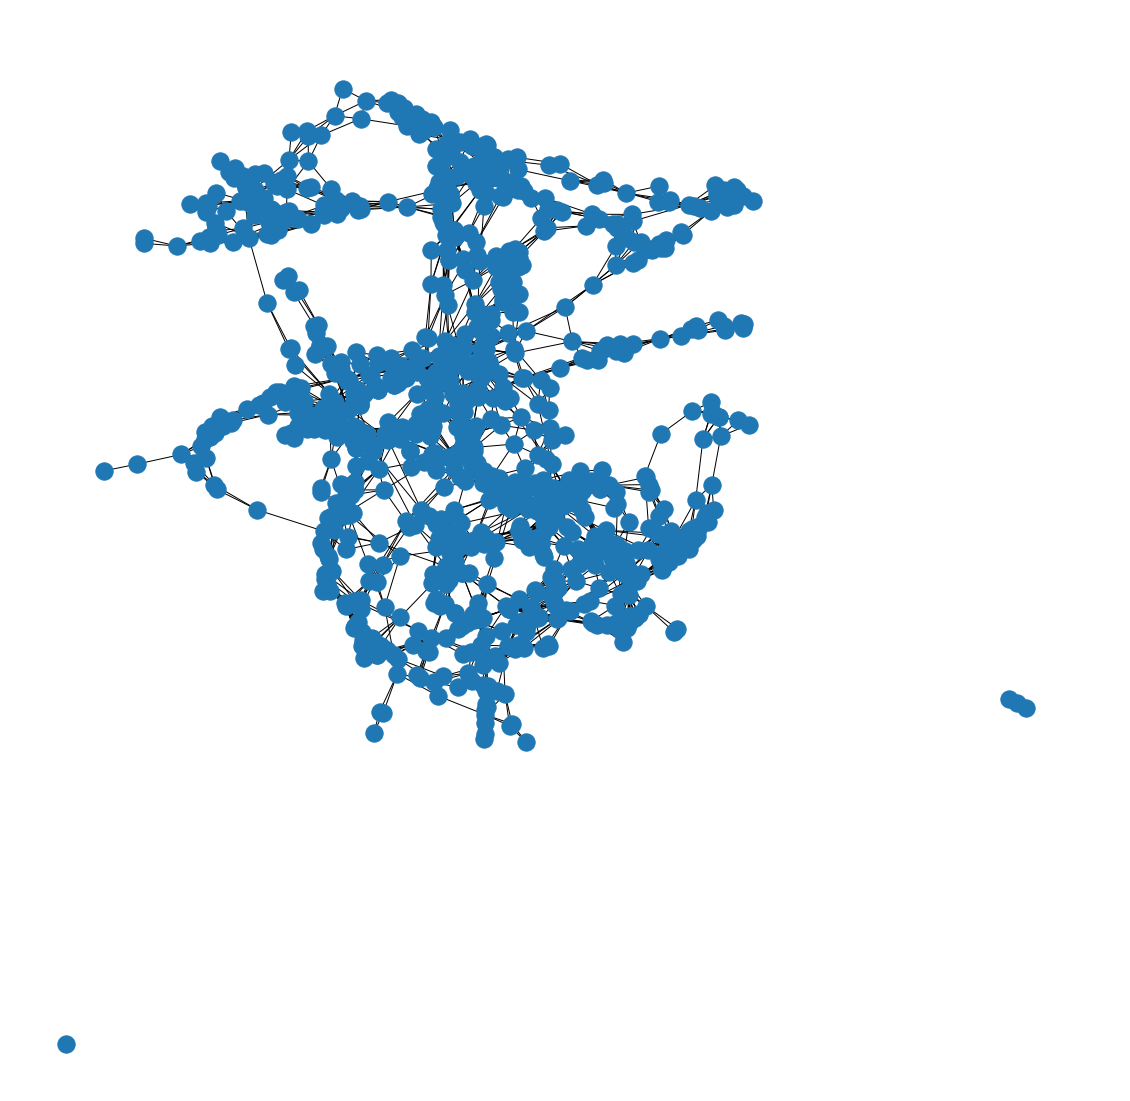

In [22]:
G = nx.random_geometric_graph(n=1000, radius=0.05)
G = nx.from_numpy_array(np.array(nx.to_pandas_adjacency(G), dtype=bool))

steps_number = int(1e6)

fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, ax=ax)

In [23]:
print(max(G.degree, key=lambda x: x[1]))
print(np.max(list(list(zip(*G.degree))[1])))

(193, 16)
16


In [24]:

print("Start SOC")
start = time()
colors, E_list = color(G, 18, steps_number)
print("Took: "+str(time()-start))


Start SOC
Current step: 0
Current step: 10000
Current step: 20000
Current step: 30000
Current step: 40000
Current step: 50000
Current step: 60000
Current step: 70000
Current step: 80000
Current step: 90000
Current step: 100000
Current step: 110000
Current step: 120000
Current step: 130000
Current step: 140000
Current step: 150000
Current step: 160000
Current step: 170000
Current step: 180000
Current step: 190000
Current step: 200000
Current step: 210000
Current step: 220000
Current step: 230000
Current step: 240000
Current step: 250000
Current step: 260000
Current step: 270000
Current step: 280000
Current step: 290000
Current step: 300000
Current step: 310000
Current step: 320000
Current step: 330000
Current step: 340000
Current step: 350000
Current step: 360000
Current step: 370000
Current step: 380000
Current step: 390000
Current step: 400000
Current step: 410000
Current step: 420000
Current step: 430000
Current step: 440000
Current step: 450000
Current step: 460000
Current step: 470

In [25]:
f = open('soc_rgg_color', 'w')
for i in colors:
    f.write(str(i)+', ')

f = open('soc_rgg_e_list', 'w')
for e in E_list:
    f.write(str(e)+', ')
f.close()


In [26]:

print("Start random")
start = time()
colors, E_list = color_random(G, 18, steps_number)
print("Took: "+str(time()-start))


Start random
Current step: 0
Current step: 10000
Current step: 20000
Current step: 30000
Current step: 40000
Current step: 50000
Current step: 60000
Current step: 70000
Current step: 80000
Current step: 90000
Current step: 100000
Current step: 110000
Current step: 120000
Current step: 130000
Current step: 140000
Current step: 150000
Current step: 160000
Current step: 170000
Current step: 180000
Current step: 190000
Current step: 200000
Current step: 210000
Current step: 220000
Current step: 230000
Current step: 240000
Current step: 250000
Current step: 260000
Current step: 270000
Current step: 280000
Current step: 290000
Current step: 300000
Current step: 310000
Current step: 320000
Current step: 330000
Current step: 340000
Current step: 350000
Current step: 360000
Current step: 370000
Current step: 380000
Current step: 390000
Current step: 400000
Current step: 410000
Current step: 420000
Current step: 430000
Current step: 440000
Current step: 450000
Current step: 460000
Current step: 

In [27]:
f = open('random_rgg_color', 'w')
for i in colors:
    f.write(str(i)+', ')

f = open('random_rgg_e_list', 'w')
for e in E_list:
    f.write(str(e)+', ')
f.close()

In [28]:

print("Start propag")
start = time()
colors, E_list = color_s(G, 18, steps_number)
print("Took: "+str(time()-start))

Start propag
Current step: 0
Current step: 10000
Current step: 20000
Current step: 30000
Current step: 40000
Current step: 50000
Current step: 60000
Current step: 70000
Current step: 80000
Current step: 90000
Current step: 100000
Current step: 110000
Current step: 120000
Current step: 130000
Current step: 140000
Current step: 150000
Current step: 160000
Current step: 170000
Current step: 180000
Current step: 190000
Current step: 200000
Current step: 210000
Current step: 220000
Current step: 230000
Current step: 240000
Current step: 250000
Current step: 260000
Current step: 270000
Current step: 280000
Current step: 290000
Current step: 300000
Current step: 310000
Current step: 320000
Current step: 330000
Current step: 340000
Current step: 350000
Current step: 360000
Current step: 370000
Current step: 380000
Current step: 390000
Current step: 400000
Current step: 410000
Current step: 420000
Current step: 430000
Current step: 440000
Current step: 450000
Current step: 460000
Current step: 

In [29]:
f = open('prop_rgg_color', 'w')
for i in colors:
    f.write(str(i)+', ')

f = open('prop_rgg_e_list', 'w')
for e in E_list:
    f.write(str(e)+', ')
f.close()

In [30]:
fsoc = open('soc_rgg_e_list', 'r')
soc_curve = list(map(int, fsoc.read().split(', ')[:-1]))

In [31]:
fr = open('random_rgg_e_list', 'r')
r_curve = list(map(int, fr.read().split(', ')[:-1]))

In [32]:
fp = open('prop_rgg_e_list', 'r')
p_curve = list(map(lambda x: int(float(x)), fp.read().split(', ')[:-1]))

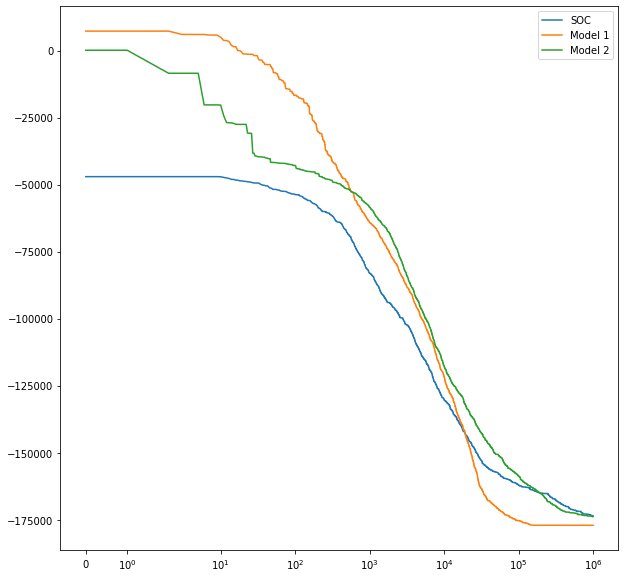

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xscale('symlog')
plt.plot(range(int(1e6)), soc_curve, label='SOC')
plt.plot(range(int(1e6)), r_curve, label='Model 1')
plt.plot(range(int(1e6)), p_curve, label='Model 2')
plt.legend()
plt.show()